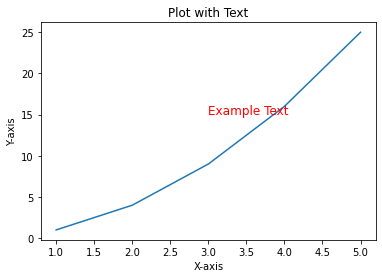

In [18]:
# Generate some data for the plot
x = [1, 2, 3, 4, 5]
y = [1, 4, 9, 16, 25]

# Plot the data
plt.plot(x, y)

# Add text to the plot
plt.text(3, 15, 'Example Text', fontsize=12, color='red')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot with Text')

# Show the plot
plt.show()

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
# from src.data.make_cifar10_dataset import CIFAR10, get_img_transformer
from torchvision import transforms
import torch.nn.functional as F
import torchvision
import pickle
from sklearn import metrics
from tqdm import tqdm
from src.models.conformal_model import ConformalModel
# from src.models.GB_quantile_regressor import GB_quantile_regressor, Conformalized_quantile_regression_logits
from mapie.quantile_regression import MapieQuantileRegressor
from src.models.CQR import CQR
from src.models.cifar10_conv_model import Cifar10ConvModel
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets.vision import VisionDataset
import torch.optim as optim
from typing import Any, Callable, Optional, Tuple
from numpy import random
from torch import nn
from src.models.oracle import Oracle
import itertools

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet



In [17]:
np.linspace(0,3,200)

array([0.        , 0.01507538, 0.03015075, 0.04522613, 0.06030151,
       0.07537688, 0.09045226, 0.10552764, 0.12060302, 0.13567839,
       0.15075377, 0.16582915, 0.18090452, 0.1959799 , 0.21105528,
       0.22613065, 0.24120603, 0.25628141, 0.27135678, 0.28643216,
       0.30150754, 0.31658291, 0.33165829, 0.34673367, 0.36180905,
       0.37688442, 0.3919598 , 0.40703518, 0.42211055, 0.43718593,
       0.45226131, 0.46733668, 0.48241206, 0.49748744, 0.51256281,
       0.52763819, 0.54271357, 0.55778894, 0.57286432, 0.5879397 ,
       0.60301508, 0.61809045, 0.63316583, 0.64824121, 0.66331658,
       0.67839196, 0.69346734, 0.70854271, 0.72361809, 0.73869347,
       0.75376884, 0.76884422, 0.7839196 , 0.79899497, 0.81407035,
       0.82914573, 0.84422111, 0.85929648, 0.87437186, 0.88944724,
       0.90452261, 0.91959799, 0.93467337, 0.94974874, 0.96482412,
       0.9798995 , 0.99497487, 1.01005025, 1.02512563, 1.04020101,
       1.05527638, 1.07035176, 1.08542714, 1.10050251, 1.11557

In [13]:
model = TemporalFusionTransformer(dropout=0.5)
model = model.load_from_checkpoint("../lightning_logs/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt")
dropout_fraction = 0.5  # New dropout fraction

# Assuming the dropout layer is named "dropout"
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.p = dropout_fraction

/Users/abdulrahman/opt/anaconda3/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/abdulrahman/opt/anaconda3/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [14]:
model

TemporalFusionTransformer(
  	"attention_head_size":               3
  	"categorical_groups":                {'special_days': ['easter_day', 'good_friday', 'new_year', 'christmas', 'labor_day', 'independence_day', 'revolution_day_memorial', 'regional_games', 'fifa_u_17_world_cup', 'football_gold_cup', 'beer_capital', 'music_fest']}
  	"causal_attention":                  True
  	"dropout":                           0.13
  	"embedding_labels":                  {'agency': {'Agency_01': 0, 'Agency_02': 1, 'Agency_03': 2, 'Agency_04': 3, 'Agency_05': 4, 'Agency_07': 5, 'Agency_08': 6, 'Agency_09': 7, 'Agency_10': 8, 'Agency_11': 9, 'Agency_12': 10, 'Agency_13': 11, 'Agency_15': 12, 'Agency_16': 13, 'Agency_17': 14, 'Agency_18': 15, 'Agency_19': 16, 'Agency_20': 17, 'Agency_21': 18, 'Agency_22': 19, 'Agency_23': 20, 'Agency_24': 21, 'Agency_25': 22, 'Agency_26': 23, 'Agency_27': 24, 'Agency_28': 25, 'Agency_29': 26, 'Agency_30': 27, 'Agency_31': 28, 'Agency_32': 29, 'Agency_33': 30, 'Agency

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

train_set = torchvision.datasets.CIFAR10(train=True, transform = transform, download=True, root='../data/processed')
test_set = torchvision.datasets.CIFAR10(train=False,  root='../data/processed',  transform = transform, download=True)

model = Cifar10ConvModel()
# model.load_state_dict(torch.load("../models/trained_model.pt"))

Files already downloaded and verified
Files already downloaded and verified


In [8]:
cal_loader = torch.utils.data.DataLoader(test_set)
cmodel = ConformalModel(model, cal_loader, 0.1)

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 10000/10000 [00:12<00:00, 774.75it/s]


Optimal T=2.4658427238464355


## Active Learning algo

- trained model in ~10% of data
- get X
- given X, messure model's uncertainty (CP) `---- ~ high --->` predict []

                                |
                               high
                                |
- query X's label 
- train model on X, y
- predict []




In [ ]:
train_set

In [ ]:
class CIFAR10_Net(nn.Module):
    def __init__(self):
        super(CIFAR10_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 1024)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
train_set.data.shape
# train_loader = torch.utils.data.DataLoader(
#     train_set, shuffle=False, batch_size=32)
# model.train()
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# for epoch in range(1):
#     for x, y in train_loader:
#         optimizer.zero_grad()
#         output = model(x)
#         loss = criterion(output, y)
#         loss.backward()
#         optimizer.step()

In [ ]:
def checkConsecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))

In [ ]:
model = Cifar10ConvModel()
l = Oracle(model, train_set=train_set, sample_size=500,test_set=test_set, n_init_training_labels=100 ,strategy="least-confidence")


In [ ]:
idx, dataset= l.get_unlabeled_data()
preds = l.get_model_predictions(dataset)
# log_probs = torch.log(preds)
# log_probs

In [ ]:
log_probs = torch.log(preds)
(preds*log_probs).sum(dim=1)

In [ ]:
t1 = torch.randint(low=10, high=100, size=(2,10))
t2 = torch.randint(low=10, high=100, size=(2,10))
(t1 == t2).all()

In [ ]:
arr = np.random.randint(low=1, high=100, size=(40,))
plt.plot(arr, "-")
plt.xlabel("Teaching round")
plt.ylabel("Accuracy")

In [ ]:
l.initialize_training_labels(1000)
l.train_model()

In [ ]:
l.get_model_accuracy()

In [ ]:
l.labeled_idx_bool[l.labeled_idx_bool==True].shape

In [ ]:
model_r = Cifar10ConvModel()
l_r = Oracle(model_r, train_set=train_set, sample_size=500,test_set=test_set ,strategy="random-sampler")

In [ ]:
l_r.teach(10)

In [ ]:
plt.plot(l_r.round_accuracies)

In [ ]:
calib_idx = np.random.randint(low=0, high=len(
    train_set), size=500)
# remove from training pool
calib_subset = torch.utils.data.Subset(train_set, calib_idx)

In [ ]:
dirpath = '../.cache/active_learning_experiments'
sample_size = [1000]
datasetname = ['Cifar10']
modelnames = ['Cifar10ConvModel']
strategies = ['least-confidence',
                'conformal-score:least-confidence', 'random-sampler']
params = list(itertools.product(datasetname, strategies, modelnames, sample_size))
lis = None
print(params)
fig = plt.figure(figsize=(8,11))
for datasetname, strategy, modelname, sample_size in params:
    cache_fname = f"{dirpath}/{datasetname}_{strategy}_{modelname}_{sample_size}.csv"
    df = pd.read_csv(cache_fname)
    str_arr = df.round_accuries.values
    # convert string to np array
    string = str_arr[0].replace("array(", "").replace("dtype=object)", "")
    trail_acc = np.array(eval(string))

    std = trail_acc.std(axis=0)
    avg = trail_acc.mean(axis=0)
    if strategy == 'random-sampler':
        plt_color = 'green'
    elif strategy == 'least-confidence':
        plt_color = 'blue'
    else :
        plt_color = 'red'
    plt.plot(avg, linestyle='-', color=plt_color, label=f"{strategy.replace('-', ' ')} mean")
    plt.plot(avg+std, ':', color=plt_color, label=f"{strategy.replace('-', ' ')} ± std")
    plt.plot(avg-std, ':', color=plt_color)
    plt.legend()
    plt.grid()
    plt.savefig('img')

In [ ]:
ls_lst = [[0.116, 0.1735, 0.2372, 0.2741, 0.3311, 0.3801, 0.4176, 0.4647, 0.4847, 0.5278, 0.5557, 0.5608, 0.5545, 0.5771, 0.612, 0.6192, 0.6134, 0.64, 0.6468, 0.6492, 0.674, 0.6683, 0.6742, 0.6774, 0.6884, 0.6953, 0.7036, 0.6959, 0.6946, 0.7059, 0.7045, 0.7215, 0.7195, 0.7201, 0.7205, 0.7088, 0.7233, 0.7122, 0.7315, 0.7263], [0.1221, 0.1684, 0.2436, 0.3181, 0.3508, 0.4129, 0.4359, 0.4499, 0.477, 0.5056, 0.5382, 0.5622, 0.5777, 0.6015, 0.6118, 0.604, 0.6216, 0.6359, 0.6247, 0.6439, 0.6645, 0.6733, 0.6771, 0.6791, 0.6793, 0.6878, 0.6853, 0.6888, 0.6806, 0.6876, 0.7075, 0.7043, 0.6981, 0.7005, 0.7065, 0.7073, 0.7148, 0.7115, 0.7178, 0.7141], [0.1292, 0.2147, 0.2244, 0.2945, 0.3631, 0.4038, 0.4207, 0.4494, 0.4869, 0.4854, 0.4866, 0.51, 0.5606, 0.5789, 0.5675, 0.6113, 0.6155, 0.6213, 0.6349, 0.6425, 0.6577, 0.661, 0.6633, 0.6693, 0.6759, 0.672, 0.673, 0.6907, 0.6921, 0.6882, 0.696, 0.6953, 0.6966, 0.7031, 0.7034, 0.7116, 0.7108, 0.7098, 0.7031, 0.719], [0.122, 0.1943, 0.2425, 0.2911, 0.324, 0.3998, 0.4309, 0.4873, 0.5019, 0.5341, 0.559, 0.5682, 0.5797, 0.5986, 0.6098, 0.6162, 0.628, 0.6501, 0.6493, 0.6584, 0.6667, 0.6563, 0.6747, 0.6811, 0.6839, 0.6846, 0.6905, 0.6954, 0.7003, 0.6887, 0.7, 0.697, 0.6939, 0.7091, 0.7176, 0.7175, 0.7102, 0.714, 0.7154, 0.7107], [0.1052, 0.1862, 0.2675, 0.2906, 0.3437, 0.376, 0.4071, 0.4315, 0.4375, 0.4573, 0.5142, 0.5315, 0.5601, 0.5743, 0.5987, 0.6065, 0.6221, 0.6228, 0.6388, 0.6373, 0.6522, 0.642, 0.6645, 0.6596, 0.669, 0.6813, 0.6816, 0.6864, 0.6904, 0.6832, 0.6917, 0.697, 0.6876, 0.6891, 0.7024, 0.6921, 0.693, 0.7092, 0.7069, 0.7003]]
rs_lst=[[0.116, 0.1916, 0.2574, 0.3131, 0.3575, 0.406, 0.448, 0.4901, 0.5009, 0.5054, 0.5359, 0.5628, 0.5941, 0.6151, 0.6083, 0.6068, 0.6262, 0.644, 0.6504, 0.6335, 0.658, 0.654, 0.6549, 0.6569, 0.6694, 0.67, 0.6728, 0.6821, 0.6785, 0.6739, 0.6845, 0.6818, 0.6909, 0.6847, 0.687, 0.6926, 0.6943, 0.6963, 0.699, 0.6968], [0.1532, 0.2568, 0.2909, 0.3497, 0.3669, 0.406, 0.4324, 0.464, 0.4951, 0.5058, 0.5368, 0.5526, 0.5857, 0.6024, 0.6095, 0.6176, 0.6264, 0.6392, 0.6469, 0.6596, 0.6565, 0.6576, 0.6692, 0.6628, 0.6674, 0.67, 0.6763, 0.6745, 0.6708, 0.6811, 0.6859, 0.6864, 0.6873, 0.6922, 0.6792, 0.69, 0.6943, 0.6936, 0.7006, 0.6962], [0.1063, 0.17, 0.2631, 0.3189, 0.3495, 0.4078, 0.4297, 0.4483, 0.4873, 0.5051, 0.496, 0.5646, 0.5589, 0.5659, 0.5938, 0.5959, 0.6126, 0.6339, 0.6406, 0.6331, 0.6475, 0.652, 0.6508, 0.6595, 0.6577, 0.6601, 0.6741, 0.6542, 0.6766, 0.6718, 0.6736, 0.6735, 0.6788, 0.6803, 0.6804, 0.6764, 0.6932, 0.6809, 0.6831, 0.7006], [0.1586, 0.2298, 0.312, 0.343, 0.3725, 0.399, 0.4504, 0.4751, 0.4936, 0.4937, 0.4982, 0.5363, 0.5445, 0.5683, 0.5887, 0.6028, 0.5995, 0.6049, 0.638, 0.64, 0.6427, 0.6402, 0.6442, 0.6625, 0.6582, 0.6593, 0.6573, 0.6728, 0.6731, 0.6708, 0.6834, 0.6704, 0.6814, 0.6796, 0.6887, 0.6906, 0.6897, 0.7015, 0.6994, 0.6943], [0.148, 0.2476, 0.282, 0.3124, 0.3611, 0.409, 0.4432, 0.461, 0.4742, 0.5184, 0.5257, 0.5489, 0.5517, 0.5748, 0.5878, 0.5872, 0.6036, 0.6061, 0.619, 0.6094, 0.6501, 0.647, 0.6448, 0.6497, 0.6495, 0.6629, 0.6567, 0.6655, 0.6631, 0.6785, 0.6603, 0.6822, 0.688, 0.6753, 0.6772, 0.6798, 0.6825, 0.6903, 0.694, 0.7022]]

In [ ]:
plt.plot(ls_lst[0], color='red')
plt.plot(rs_lst[0], color='blue')

In [ ]:
type(int('10'))

In [ ]:
# tensor([[ 0.0569, -0.2475,  0.0737, -0.3429],
#         [-0.2993,  0.9138,  0.9337, -1.6864],
#         [ 0.1132,  0.7892, -0.1003,  0.5688],
#         [ 0.3637, -0.9906, -0.4752, -1.5197]])


0.0569+(-0.2475)+0.0737+-0.3429

In [ ]:
np.arange(10,-1,-1)

In [4]:
params = {
    'sample_size': 150,
    'strategy': 'least-confidence'
}
model = Cifar10ConvModel()
o = Oracle(model=model, train_set=train_set, test_set=test_set, **params)
o.teach(1)
sample_idx = o.query_sample_idx()
labeled_idx = o.get_unlabeled_data()[0]
# check queried indecies are unlabeled
# assert np.in1d(labeled_idx, sample_idx()).shape[0] == 0

  0%|          | 0/1 [01:24<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
sample_idx

In [3]:
t = torch.tensor(1)

In [5]:
t.item()

1